In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
!pip install fbprophet
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima.arima import auto_arima
std=StandardScaler()



# New Section

In [6]:
covid=pd.read_csv("/covid_19_data.csv")
covid.tail(5)

SNo ObservationDate     Province/State  ... Confirmed  Deaths  Recovered
156287  156288      11/15/2020  Zaporizhia Oblast  ...   18484.0   164.0     3021.0
156288  156289      11/15/2020            Zeeland  ...    5041.0    86.0        0.0
156289  156290      11/15/2020           Zhejiang  ...    1291.0     1.0     1279.0
156290  156291      11/15/2020    Zhytomyr Oblast  ...   22225.0   368.0    12266.0
156291  156292      11/15/2020       Zuid-Holland  ...  129188.0  2031.0        0.0

[5 rows x 8 columns]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [8]:
covid.head()


SNo ObservationDate Province/State  ... Confirmed Deaths  Recovered
0    1      01/22/2020          Anhui  ...       1.0    0.0        0.0
1    2      01/22/2020        Beijing  ...      14.0    0.0        0.0
2    3      01/22/2020      Chongqing  ...       6.0    0.0        0.0
3    4      01/22/2020         Fujian  ...       1.0    0.0        0.0
4    5      01/22/2020          Gansu  ...       0.0    0.0        0.0

[5 rows x 8 columns]

Observing the data : Total number of countries

In [9]:
print(covid['Country/Region'].unique())
No_of_countries = len(pd.unique(covid['Country/Region']))
print("No of countries = ",No_of_countries)

['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Saint Barthelemy'
 'Hungary' 'Faroe Islands' 'Gibraltar' 'Liechtenstein' 'Poland' 'Tunisia

In [10]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (156292, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     44313
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [11]:
#Dropping column as SNo is of no use
covid.drop(["SNo"],1,inplace=True)
covid.head()



ObservationDate Province/State  Country/Region  ... Confirmed  Deaths  Recovered
0      01/22/2020          Anhui  Mainland China  ...       1.0     0.0        0.0
1      01/22/2020        Beijing  Mainland China  ...      14.0     0.0        0.0
2      01/22/2020      Chongqing  Mainland China  ...       6.0     0.0        0.0
3      01/22/2020         Fujian  Mainland China  ...       1.0     0.0        0.0
4      01/22/2020          Gansu  Mainland China  ...       0.0     0.0        0.0

[5 rows x 7 columns]

In [12]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])
covid.head()

ObservationDate Province/State  Country/Region  ... Confirmed  Deaths  Recovered
0      2020-01-22          Anhui  Mainland China  ...       1.0     0.0        0.0
1      2020-01-22        Beijing  Mainland China  ...      14.0     0.0        0.0
2      2020-01-22      Chongqing  Mainland China  ...       6.0     0.0        0.0
3      2020-01-22         Fujian  Mainland China  ...       1.0     0.0        0.0
4      2020-01-22          Gansu  Mainland China  ...       0.0     0.0        0.0

[5 rows x 7 columns]

In [14]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [15]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [16]:
grouped_country.head(10)

Confirmed  ...  log_active
Country/Region  ObservationDate             ...            
 Azerbaijan     2020-02-28             1.0  ...    0.000000
('St. Martin',) 2020-03-10             2.0  ...    0.693147
Afghanistan     2020-02-24             1.0  ...    0.000000
                2020-02-25             1.0  ...    0.000000
                2020-02-26             1.0  ...    0.000000
                2020-02-27             1.0  ...    0.000000
                2020-02-28             1.0  ...    0.000000
                2020-02-29             1.0  ...    0.000000
                2020-03-01             1.0  ...    0.000000
                2020-03-02             1.0  ...    0.000000

[10 rows x 6 columns]

In [19]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [20]:
datewise.head()



Confirmed  Recovered  Deaths Days Since
ObservationDate                                         
2020-01-22           555.0       28.0    17.0     0 days
2020-01-23           653.0       30.0    18.0     1 days
2020-01-24           941.0       36.0    26.0     2 days
2020-01-25          1438.0       39.0    42.0     3 days
2020-01-26          2118.0       52.0    56.0     4 days

In [21]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])


Basic Information
Totol number of countries with Disease Spread:  226
Total number of Confirmed Cases around the World:  54370186.0
Total number of Recovered Cases around the World:  34955148.0
Total number of Deaths Cases around the World:  1317139.0
Total number of Active Cases around the World:  18097899.0
Total number of Closed Cases around the World:  36272287.0


In [22]:
print("Approximations per day and hour")
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))


Approximations per day and hour
Approximate number of Confirmed Cases per Day around the World:  181840.0
Approximate number of Recovered Cases per Day around the World:  116907.0
Approximate number of Death Cases per Day around the World:  4405.0
Approximate number of Confirmed Cases per hour around the World:  7577.0
Approximate number of Recovered Cases per hour around the World:  4871.0
Approximate number of Death Cases per hour around the World:  184.0


In [23]:

fig = px.choropleth(covid, locations="Country/Region", 
                    color=np.log(covid["Confirmed"]),
                    locationmode='country names', hover_name="Country/Region", 
                    animation_frame=covid["ObservationDate"].dt.strftime('%Y-%m-%d'),
                    title='Cases over time', color_continuous_scale=px.colors.sequential.matter)
fig.update(layout_coloraxis_showscale=False)
fig.show()


In [24]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [25]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [26]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases ",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

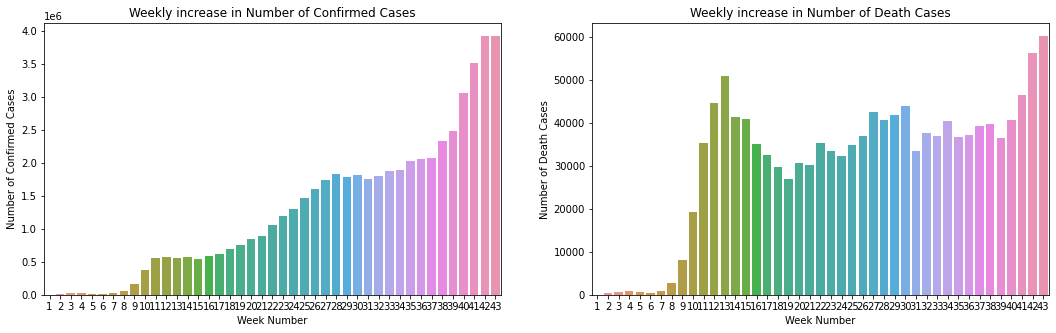

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")


In [28]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.179927058208271
Median Mortality Rate 3.682147271692958
Average Recovery Rate 46.60765271723479
Median Recovery Rate 50.822438539150205


In [29]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  181838.0
Average increase in number of Recovered Cases every day:  116907.0
Average increase in number of Deaths Cases every day:  4405.0


In [30]:
#Extracting USA data 
covid_us=covid[covid['Country/Region']=="US"]

#Extracting other countries for comparison of worst affected countries
covid_spain=covid[covid['Country/Region']=="Spain"]
covid_india=covid[covid['Country/Region']=="India"]
covid_italy=covid[covid['Country/Region']=="Italy"]
covid_iran=covid[covid['Country/Region']=="Iran"]
covid_france=covid[covid['Country/Region']=="France"]
covid_uk=covid[covid['Country/Region']=="UK"]
covid_brazil=covid[covid['Country/Region']=="Brazil"]
covid_russia=covid[covid['Country/Region']=="Russia"]

#Extracting data of neighbouring countries
covid_canada=covid[covid['Country/Region']=="Canada"]
covid_mexico=covid[covid['Country/Region']=="Mexico"]


In [31]:
#Converting the date into Datetime format
covid_us["ObservationDate"]=pd.to_datetime(covid_us["ObservationDate"])
covid_spain["ObservationDate"]=pd.to_datetime(covid_spain["ObservationDate"])
covid_india["ObservationDate"]=pd.to_datetime(covid_india["ObservationDate"])
covid_italy["ObservationDate"]=pd.to_datetime(covid_italy["ObservationDate"])
covid_iran["ObservationDate"]=pd.to_datetime(covid_iran["ObservationDate"])
covid_france["ObservationDate"]=pd.to_datetime(covid_france["ObservationDate"])
covid_uk["ObservationDate"]=pd.to_datetime(covid_uk["ObservationDate"])
covid_brazil["ObservationDate"]=pd.to_datetime(covid_brazil["ObservationDate"])
covid_russia["ObservationDate"]=pd.to_datetime(covid_russia["ObservationDate"])
covid_canada["ObservationDate"]=pd.to_datetime(covid_canada["ObservationDate"])
covid_mexico["ObservationDate"]=pd.to_datetime(covid_mexico["ObservationDate"])


In [32]:
#Grouping the data based on the Date 
us_datewise=covid_us.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
spain_datewise=covid_spain.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
india_datewise=covid_india.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
italy_datewise=covid_italy.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
iran_datewise=covid_iran.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
france_datewise=covid_france.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
uk_datewise=covid_uk.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
brazil_datewise=covid_brazil.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
russia_datewise=covid_russia.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
canada_datewise=covid_canada.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
mexico_datewise=covid_mexico.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})


In [33]:
#Adding week column to perfom weekly analysis further ahead
us_datewise["WeekofYear"]=us_datewise.index.weekofyear
spain_datewise["WeekofYear"]=spain_datewise.index.weekofyear
india_datewise["WeekofYear"]=india_datewise.index.weekofyear
italy_datewise["WeekofYear"]=italy_datewise.index.weekofyear
iran_datewise["WeekofYear"]=iran_datewise.index.weekofyear
france_datewise["WeekofYear"]=france_datewise.index.weekofyear
uk_datewise["WeekofYear"]=uk_datewise.index.weekofyear
brazil_datewise["WeekofYear"]=brazil_datewise.index.weekofyear
russia_datewise["WeekofYear"]=russia_datewise.index.weekofyear
canada_datewise["WeekofYear"]=canada_datewise.index.weekofyear
mexico_datewise["WeekofYear"]=mexico_datewise.index.weekofyear

In [34]:
us_datewise["Days Since"]=(us_datewise.index-india_datewise.index[0])
us_datewise["Days Since"]=us_datewise["Days Since"].dt.days

In [35]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [36]:
X=countrywise[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
X=std.fit_transform(X) 

In [37]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

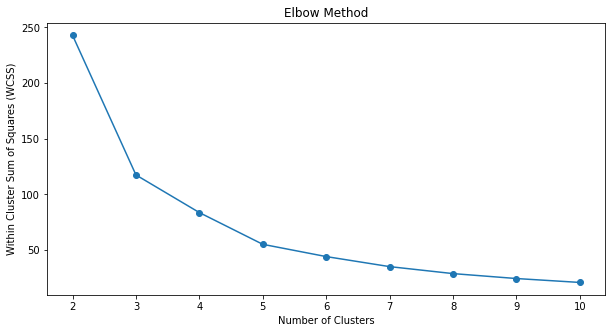

In [38]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcss,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

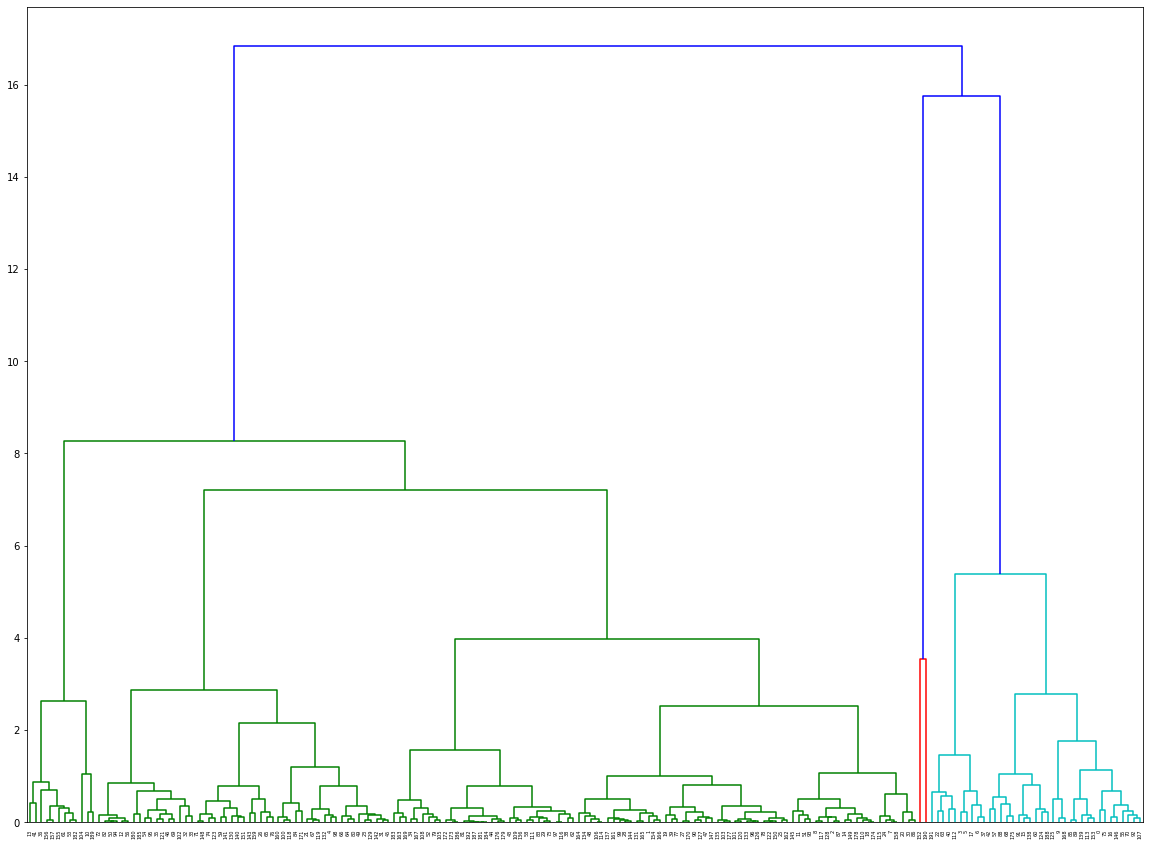

In [39]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))


In [40]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

In [41]:
countrywise["Clusters"]=clf_final.predict(X)

In [42]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

In [43]:
print("Avergae Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Avergae Mortality Rate of Cluster 0:  2.012316099534356
Avergae Recovery Rate of Cluster 0:  85.79790058380233
Avergae Mortality Rate of Cluster 1:  25.71053196053196
Avergae Recovery Rate of Cluster 1:  33.63899613899614
Avergae Mortality Rate of Cluster 2:  1.8661742403440462
Avergae Recovery Rate of Cluster 2:  35.17660036648923


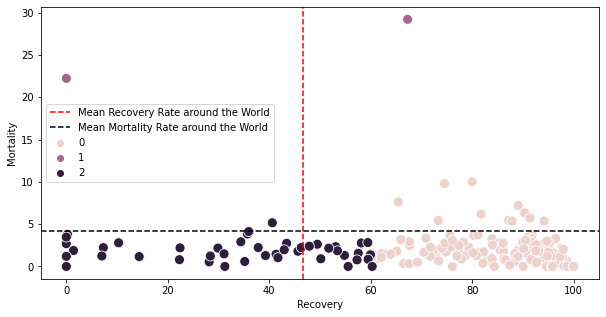

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [45]:
print("Few Countries belonging to Cluster 0: ",list(countrywise[countrywise["Clusters"]==0].head(10).index))
print("Few Countries belonging to Cluster 1: ",list(countrywise[countrywise["Clusters"]==1].head(10).index))
print("Few Countries belonging to Cluster 2: ",list(countrywise[countrywise["Clusters"]==2].head(10).index))

Few Countries belonging to Cluster 0:  ['India', 'Brazil', 'Russia', 'Argentina', 'Colombia', 'Mexico', 'Peru', 'Germany', 'Iran', 'South Africa']
Few Countries belonging to Cluster 1:  ['Yemen', 'MS Zaandam']
Few Countries belonging to Cluster 2:  ['US', 'France', 'Spain', 'UK', 'Italy', 'Poland', 'Ukraine', 'Belgium', 'Netherlands', 'Switzerland']


Prediction using Machine Learning Models

Linear Regression Model for Confirm Cases Prediction

In [46]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [47]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [48]:
lin_reg=LinearRegression(normalize=True)

In [49]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [50]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [51]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [52]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  14366505.585641908


In [53]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

Polynomial Regression for Prediction of Confirmed Cases

In [54]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
poly = PolynomialFeatures(degree = 8) 
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [55]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  862318.1492832925


In [56]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [57]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [58]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  10286744.183962515


In [60]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [61]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

Dates  ...  SVM Prediction
0 2020-11-16  ... 69927483.212344
1 2020-11-17  ... 71232010.372132
2 2020-11-18  ... 72558461.784956
3 2020-11-19  ... 73907131.237419
4 2020-11-20  ... 75278315.458859

[5 rows x 4 columns]

In [62]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [63]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6551.178, Time=0.12 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.314 seconds


ARIMA(maxiter=50, method='lbfgs', order=(4, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [64]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  275830.06264050334


In [65]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [66]:
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

Dates  Linear Regression Prediction  ...  SVM Prediction  AR Model Prediction
0 2020-11-16               37417973.690946  ... 69927483.212344      54498625.820083
1 2020-11-17               37573075.145143  ... 71232010.372132      55040887.685055
2 2020-11-18               37728176.599340  ... 72558461.784956      55584723.051217
3 2020-11-19               37883278.053537  ... 73907131.237419      56130497.902658
4 2020-11-20               38038379.507734  ... 75278315.458859      56678345.002484

[5 rows x 5 columns]

In [67]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()
model_ma= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.12 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.218 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [68]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  205750.14706756314


In [69]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


In [70]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

Dates  ...  MA Model Prediction
0 2020-11-16  ...      54657721.990664
1 2020-11-17  ...      55216316.544967
2 2020-11-18  ...      55777608.877786
3 2020-11-19  ...      56341598.989121
4 2020-11-20  ...      56908286.878972

[5 rows x 6 columns]

In [71]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=6598.046, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6561.739, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=6682.732, Time=0.36 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=6559.129, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=6530.336, Time=0.19 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=6606.357, Time=0.25 sec

Best model:  ARIMA(3,2,1)

ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [72]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  291923.7983333128


In [73]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [74]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

Dates  ...  ARIMA Model Prediction
0 2020-11-16  ...         54492427.455490
1 2020-11-17  ...         55041294.941118
2 2020-11-18  ...         55592427.236888
3 2020-11-19  ...         56145970.098767
4 2020-11-20  ...         56702104.098764

[5 rows x 7 columns]

In [75]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

Model Name  Root Mean Squared Error
4         Moving Average Model (MA)            205750.147068
3        Auto Regressive Model (AR)            275830.062641
5                       ARIMA Model            291923.798333
1             Polynomial Regression            862318.149283
2  Support Vector Machine Regressor          10286744.183963
0                 Linear Regression          14366505.585642